# Segmentation of eye blood vessels - UNet

Libraries:

In [8]:
import os
import cv2
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import imantics
from PIL import Image
from skimage.transform import resize
from sklearn.model_selection import train_test_split
%matplotlib inline

In [9]:
images_dir ='./images'
masks_dir = './labels'

In [10]:
images_listdir = os.listdir(images_dir)
masks_listdir = os.listdir(masks_dir)
random_images = np.random.choice(images_listdir, size = 9, replace = False)

In [11]:
print(len(images_listdir))
print(len(masks_listdir))

19
19


In [12]:
image_size=512
input_image_size=(512,512)

In [13]:
def read_image(path):
    img = cv2.imread(path)
    img = cv2.resize(img, (image_size, image_size))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [14]:
number=200

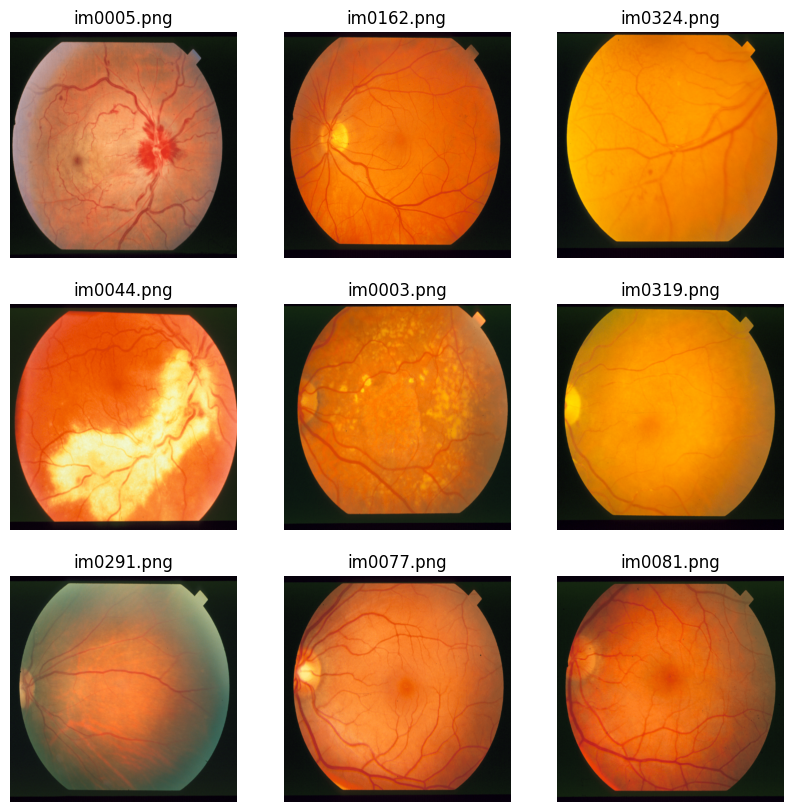

In [15]:
rows = 3
cols = 3
fig, ax = plt.subplots(rows, cols, figsize = (10,10))
for i, ax in enumerate(ax.flat):
    if i < len(random_images):
        img = read_image(f"{images_dir}/{random_images[i]}")
        ax.set_title(f"{random_images[i]}")
        ax.imshow(img)
        ax.axis('off')

im0005.vk
im0162.vk
im0324.vk
im0044.vk
im0003.vk
im0319.vk
im0291.vk
im0077.vk
im0081.vk


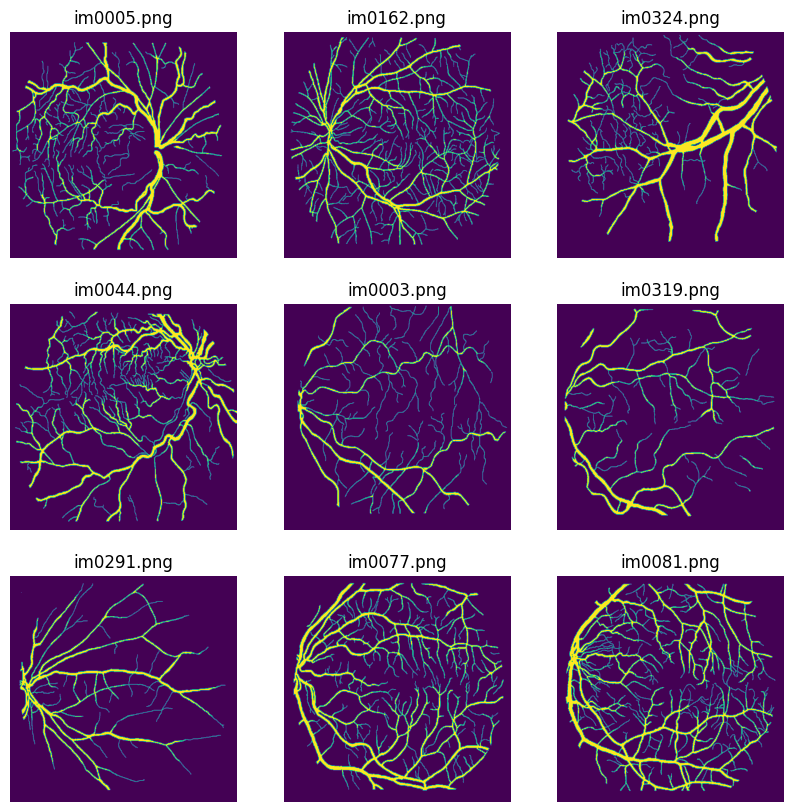

In [16]:
fig, ax = plt.subplots(rows, cols, figsize = (10,10))
for i, ax in enumerate(ax.flat):
    if i < len(random_images):
        file=random_images[i]
        file = file[0:(len(file)-4)] + '.vk.png'
        print(file[0:(len(file)-4)])
        if os.path.exists(os.path.join(masks_dir,file)):
            img = read_image(f"{masks_dir}/{file}")
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            ax.set_title(f"{random_images[i]}")
            ax.imshow(img)
            ax.axis('off')
        else:
            print('not exist')

In [17]:
MASKS=np.zeros((1,image_size, image_size, 1), dtype=bool)
IMAGES=np.zeros((1,image_size, image_size, 3),dtype=np.uint8)

for j,file in enumerate(images_listdir[0:number]):   ##the smaller, the faster
    try:
        image = read_image(f"{images_dir}/{file}")
        image_ex = np.expand_dims(image, axis=0)
        IMAGES = np.vstack([IMAGES, image_ex])
        mask = read_image(f"{masks_dir}/{file[0:(len(file)-4)] + '.vk.png'}") 
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        mask = mask.reshape(512,512,1)
        mask_ex = np.expand_dims(mask, axis=0)    
        MASKS = np.vstack([MASKS, mask_ex])
    except:
        print(file)
        continue

In [18]:
images=np.array(IMAGES)[1:number+1]
masks=np.array(MASKS)[1:number+1]
print(images.shape,masks.shape)

(19, 512, 512, 3) (19, 512, 512, 1)


In [19]:
images_train, images_test, masks_train, masks_test = train_test_split(
    images, masks, test_size=0.2, random_state=42)

print(len(images_train), len(masks_train))

15 15


In [20]:
len(images_test)

4

# Unet

In [22]:
img_data = np.array(IMAGES)[1:21]
msk_data = np.array(MASKS)[1:21]
print(img_data.shape, msk_data.shape)

(19, 512, 512, 3) (19, 512, 512, 1)


Division into training and test sets

In [23]:
train_images, test_images, train_masks, test_masks = train_test_split(img_data, msk_data, test_size=0.2, random_state=42)
print("Treningowe:", len(train_images), "Testowe:", len(test_images))

Treningowe: 15 Testowe: 4


Expanding the training dataset by augmentation

In [24]:
aug_train_images = []
aug_train_masks = []

for img, msk in zip(train_images, train_masks):
    aug_train_images.extend([img, cv2.flip(img, 0), cv2.flip(img, 1), cv2.flip(img, -1)])
    aug_train_masks.extend([msk.squeeze(), cv2.flip(msk, 0).squeeze(), cv2.flip(msk, 1).squeeze(), cv2.flip(msk, -1).squeeze()])

Converting data to a NumPy array

In [25]:
aug_train_images = np.array(aug_train_images)
aug_train_masks = np.array([np.expand_dims(msk.squeeze(), axis=-1).astype(np.float32) / 255.0 for msk in aug_train_masks])

In [26]:
test_masks = np.array([np.expand_dims(msk.squeeze(), axis=-1).astype(np.float32) / 255.0 for msk in test_masks])

In [27]:
print(aug_train_images.shape, aug_train_masks.shape)
print(type(aug_train_images), type(aug_train_masks))
print(test_images.shape, test_masks.shape)
print(type(test_images), type(test_images))

(60, 512, 512, 3) (60, 512, 512, 1)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(4, 512, 512, 3) (4, 512, 512, 1)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


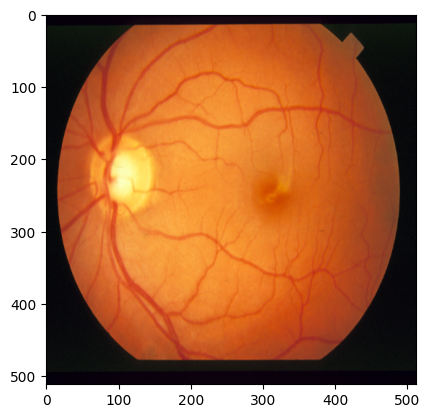

In [28]:
plt.imshow(test_images[2])

In [22]:
def conv_block(x, filters, kernel_size=3, activation='relu'):
    x = tf.keras.layers.Conv2D(filters, kernel_size, padding="same", kernel_initializer='he_normal')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation)(x)
    x = tf.keras.layers.Conv2D(filters, kernel_size, padding="same", kernel_initializer='he_normal')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation)(x)
    return x

def encoder_layer(x, filters, kernel_size=3):
    skip = conv_block(x, filters, kernel_size)
    pool = tf.keras.layers.MaxPooling2D((2, 2))(skip)
    return skip, pool

def decoder_layer(x, skip, filters, kernel_size=3):
    x = tf.keras.layers.Conv2DTranspose(filters, (2, 2), strides=2, padding="same", kernel_initializer='he_normal')(x)
    x = tf.keras.layers.Concatenate()([x, skip])
    x = conv_block(x, filters, kernel_size)
    return x

def create_unet_model(input_shape, filters=[64, 128, 256, 512, 1024], kernel_size=3):
    inputs = tf.keras.layers.Input(input_shape)

    s1, p1 = encoder_layer(inputs, filters[0], kernel_size)
    s2, p2 = encoder_layer(p1, filters[1], kernel_size)
    s3, p3 = encoder_layer(p2, filters[2], kernel_size)
    s4, p4 = encoder_layer(p3, filters[3], kernel_size)

    bridge = conv_block(p4, filters[4], kernel_size)

    d1 = decoder_layer(bridge, s4, filters[3], kernel_size)
    d2 = decoder_layer(d1, s3, filters[2], kernel_size)
    d3 = decoder_layer(d2, s2, filters[1], kernel_size)
    d4 = decoder_layer(d3, s1, filters[0], kernel_size)
    outputs = tf.keras.layers.Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = tf.keras.models.Model(inputs, outputs, name="Custom_UNet_Model")
    return model

unet_model = create_unet_model((512, 512, 3))
unet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2)])


In [23]:
dataset = tf.data.Dataset.from_tensor_slices((aug_train_images, aug_train_masks))
dataset = dataset.shuffle(buffer_size=100).batch(8).repeat().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_masks))
val_dataset = val_dataset.batch(8).repeat().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

training_history = unet_model.fit(
    dataset, 
    validation_data=val_dataset, 
    epochs=30, 
    steps_per_epoch=15, 
    validation_steps=10,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint('custom_unet_model_v33.h5', save_best_only=True),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    ]
)

evaluation_results = unet_model.evaluate(test_images, test_masks)
print("Wyniki ewaluacji modelu:", evaluation_results)

Epoch 1/30
15/15 [==============================] - ETA: 0s - loss: 0.5083 - accuracy: 0.7406 - mean_io_u: 0.4615 

c:\Users\marta\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


15/15 [==============================] - 680s 45s/step - loss: 0.5083 - accuracy: 0.7406 - mean_io_u: 0.4615 - val_loss: 8348765.0000 - val_accuracy: 0.0678 - val_mean_io_u: 0.0342
Epoch 2/30
15/15 [==============================] - 650s 45s/step - loss: 0.3186 - accuracy: 0.8581 - mean_io_u: 0.4620 - val_loss: 117306.6406 - val_accuracy: 0.0747 - val_mean_io_u: 0.0382
Epoch 3/30
15/15 [==============================] - 646s 43s/step - loss: 0.2681 - accuracy: 0.8758 - mean_io_u: 0.4615 - val_loss: 1116.9451 - val_accuracy: 0.0836 - val_mean_io_u: 0.0489
Epoch 4/30
15/15 [==============================] - 626s 42s/step - loss: 0.2350 - accuracy: 0.8831 - mean_io_u: 0.4610 - val_loss: 95.9191 - val_accuracy: 0.1378 - val_mean_io_u: 0.1217
Epoch 5/30
15/15 [==============================] - 653s 43s/step - loss: 0.2098 - accuracy: 0.8888 - mean_io_u: 0.4617 - val_loss: 41.5683 - val_accuracy: 0.8691 - val_mean_io_u: 0.4685
Epoch 6/30
15/15 [==============================] - 615s 41s/step

Train

In [32]:
def show_result(idx, og, unet, target, p):
    
    fig, axs = plt.subplots(1, 3, figsize=(12,12))
    axs[0].set_title("Original "+str(idx) )
    axs[0].imshow(og)
    axs[0].axis('off')
    
    axs[1].set_title("U-Net: p>"+str(p))
    axs[1].imshow(unet)
    axs[1].axis('off')
    
    axs[2].set_title("Ground Truth")
    axs[2].imshow(target)
    axs[2].axis('off')

    plt.show()

In [33]:
unet_predict = unet_model.predict(images_test)

1/1 [==============================] - 4s 4s/step


In [39]:
len(test_masks[0])

512

In [29]:
from tensorflow.keras.models import load_model

# Załaduj wytrenowany model
unet_model = load_model('custom_unet_model_v33.h5', compile=False)
unet_predict = unet_model.predict(images_test)

1/1 [==============================] - 5s 5s/step


In [30]:
r1,r2,r3,r4=0.5,0.8,0.9,0.99

In [31]:
unet_predict1 = (unet_predict > r1).astype(np.uint8)
unet_predict2 = (unet_predict > r2).astype(np.uint8)
unet_predict3 = (unet_predict > r3).astype(np.uint8)
unet_predict4 = (unet_predict > r4).astype(np.uint8)

## Statistical analysis

In [46]:
import numpy as np
import random
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

In [45]:
# show_test_idx = random.sample(range(len(unet_predict)), 3)
# for idx in show_test_idx: 
#     show_result(idx, images_test[idx], unet_predict1[idx], masks_test[idx], r1)
#     show_result(idx, images_test[idx], unet_predict2[idx], masks_test[idx], r2)
#     show_result(idx, images_test[idx], unet_predict3[idx], masks_test[idx], r3)
#     show_result(idx, images_test[idx], unet_predict4[idx], masks_test[idx], r4)
#     print()

1/1 [==============================] - 5s 5s/step


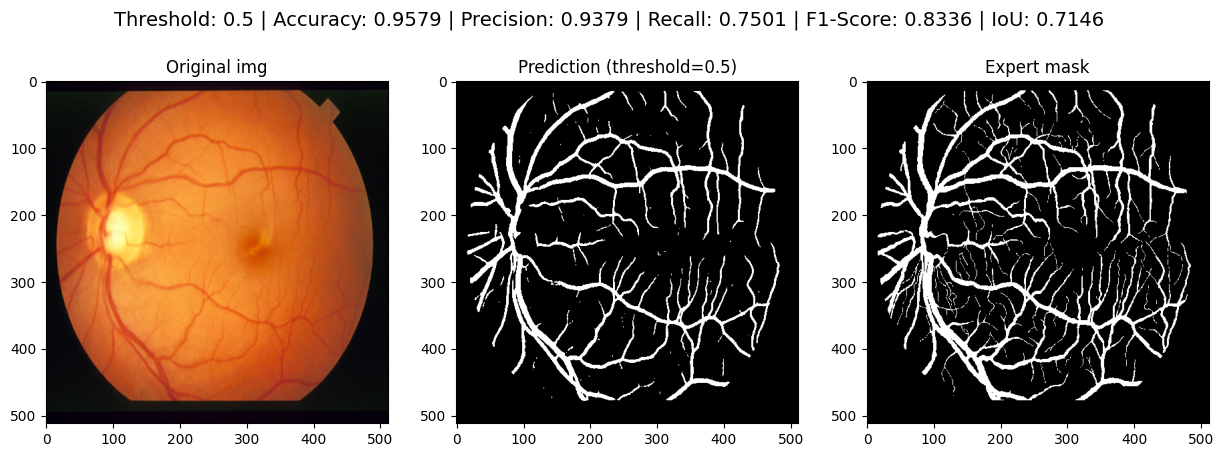

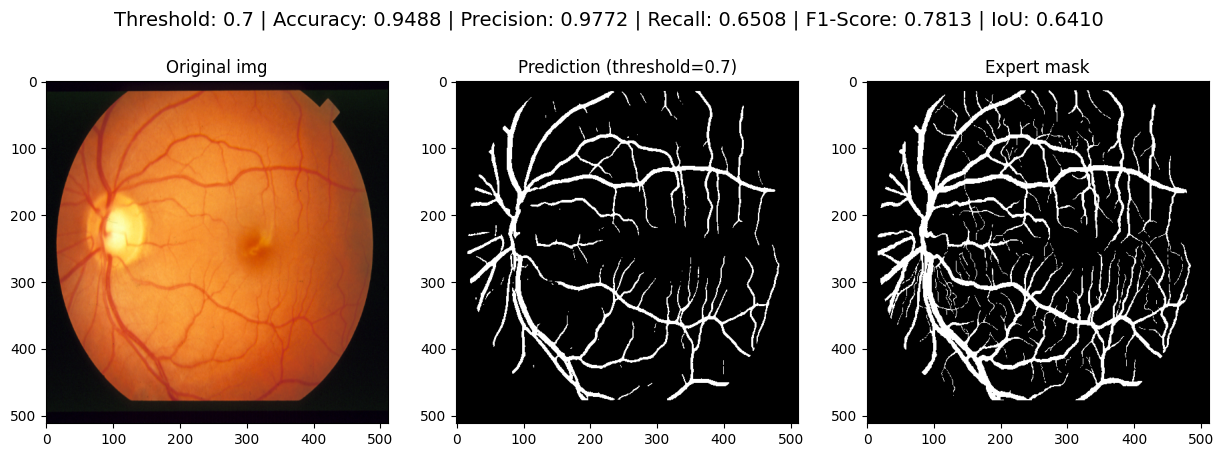

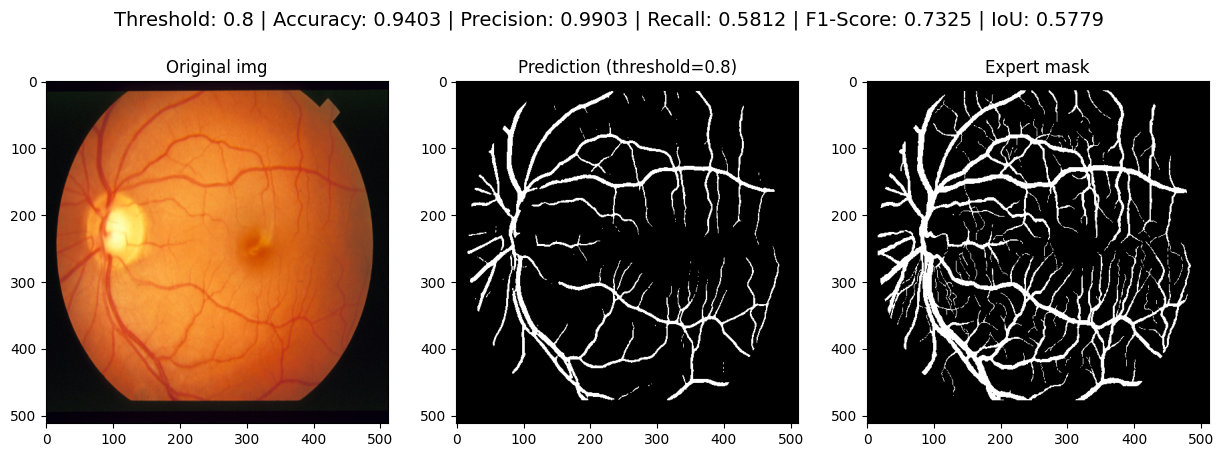

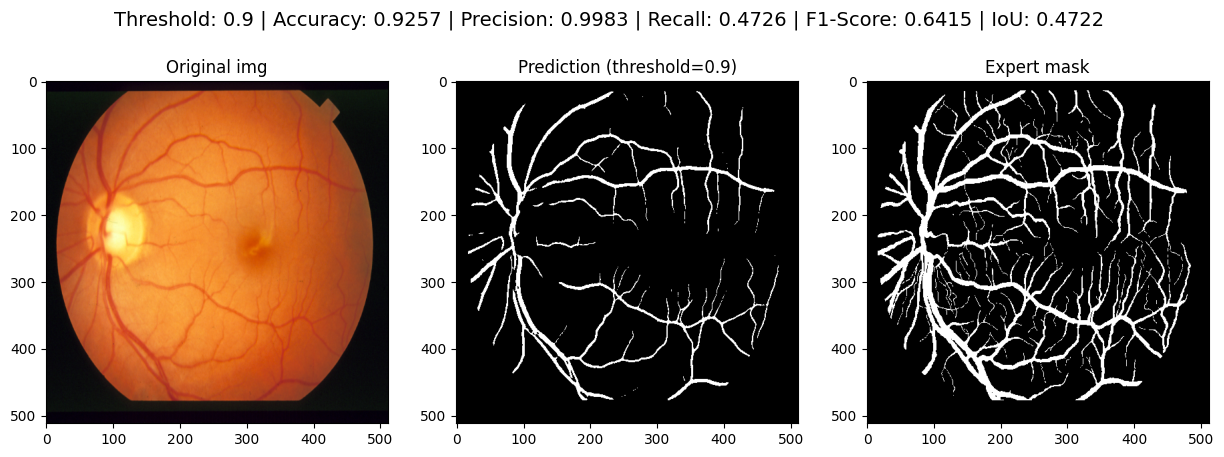

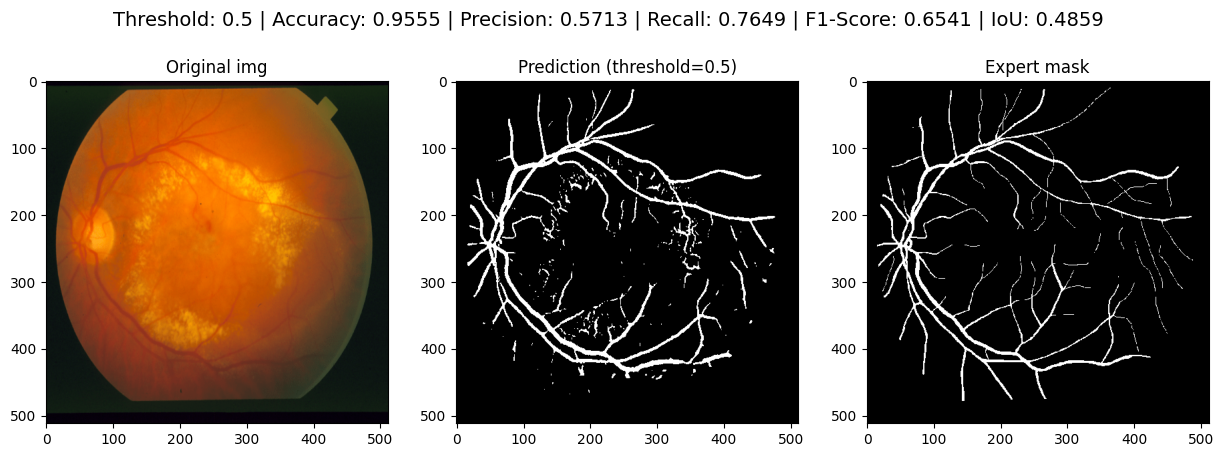

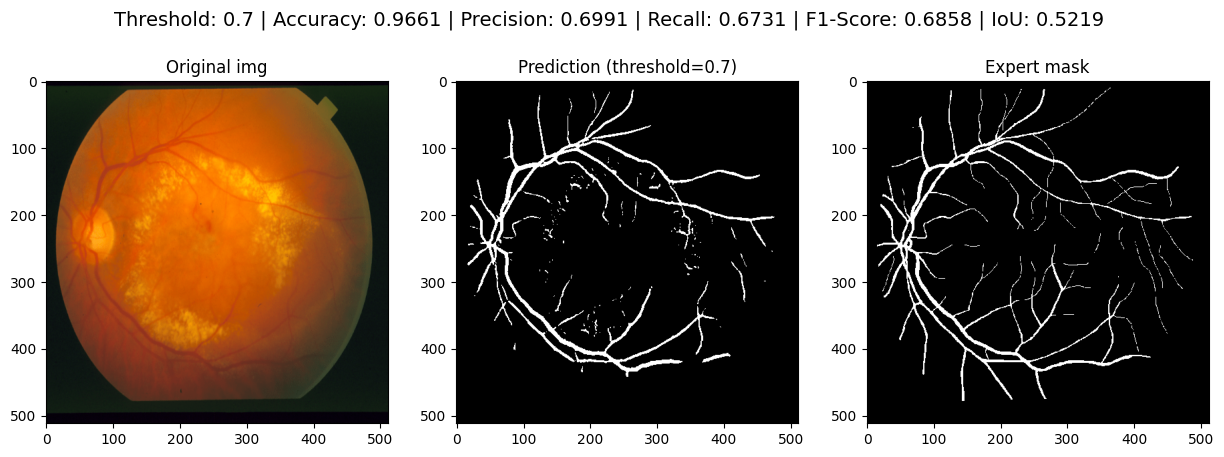

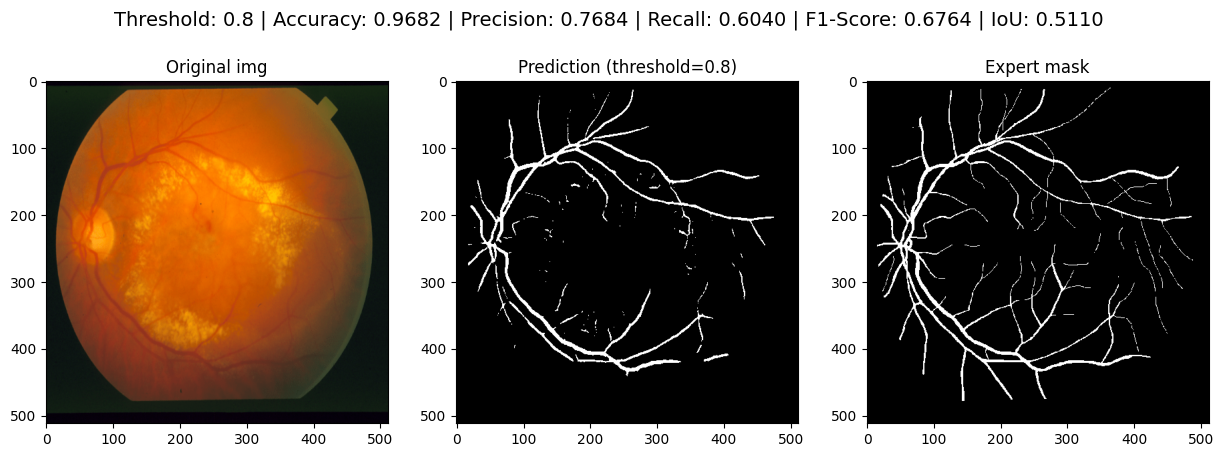

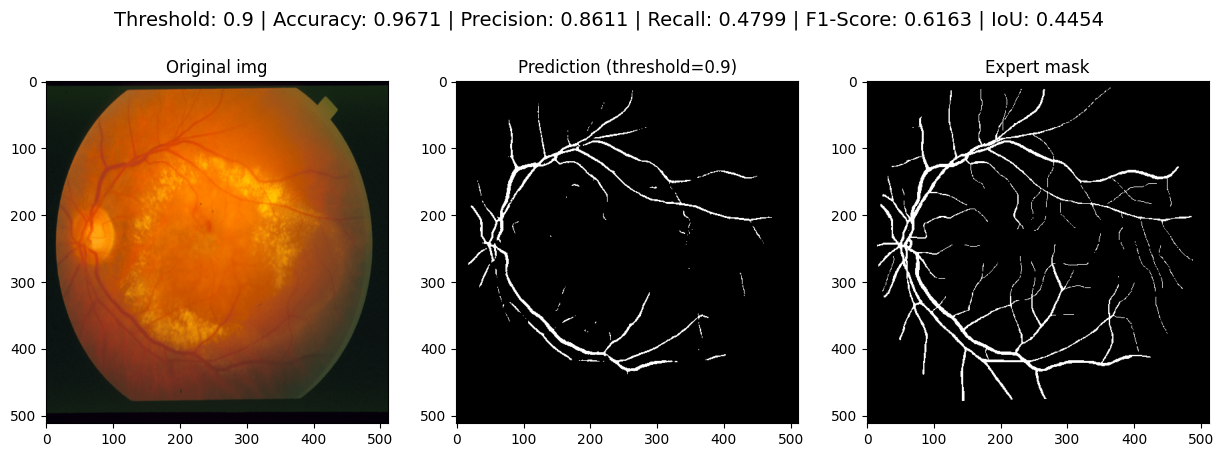

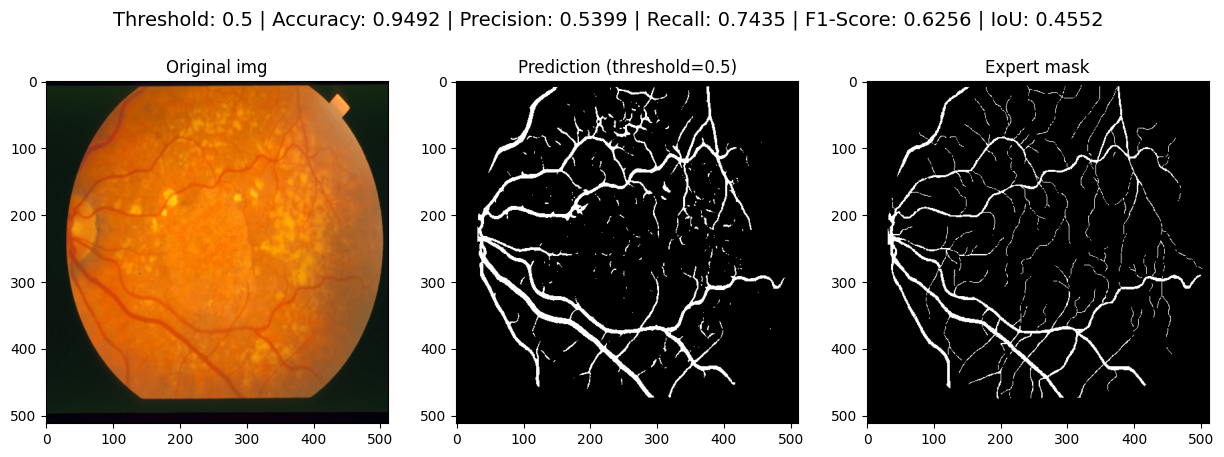

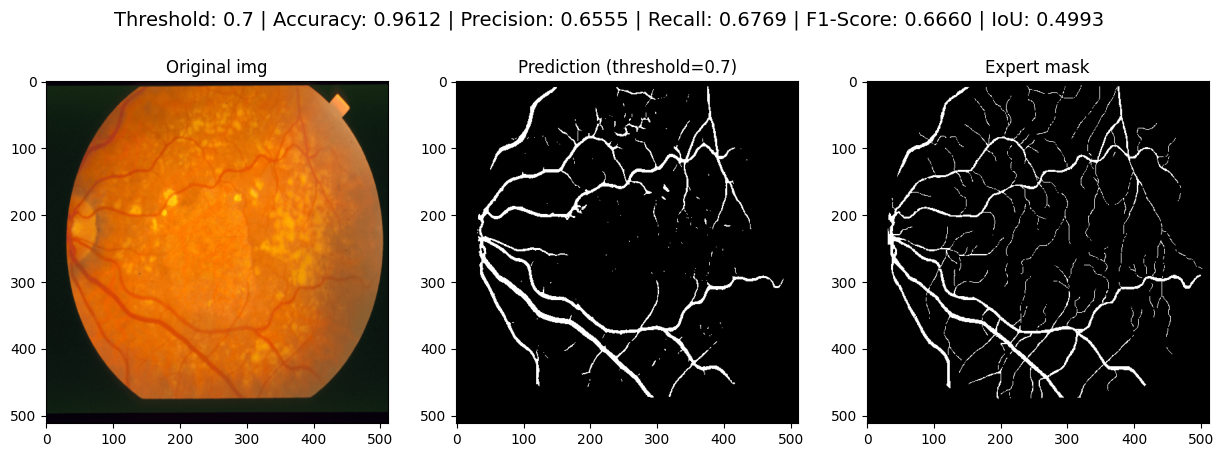

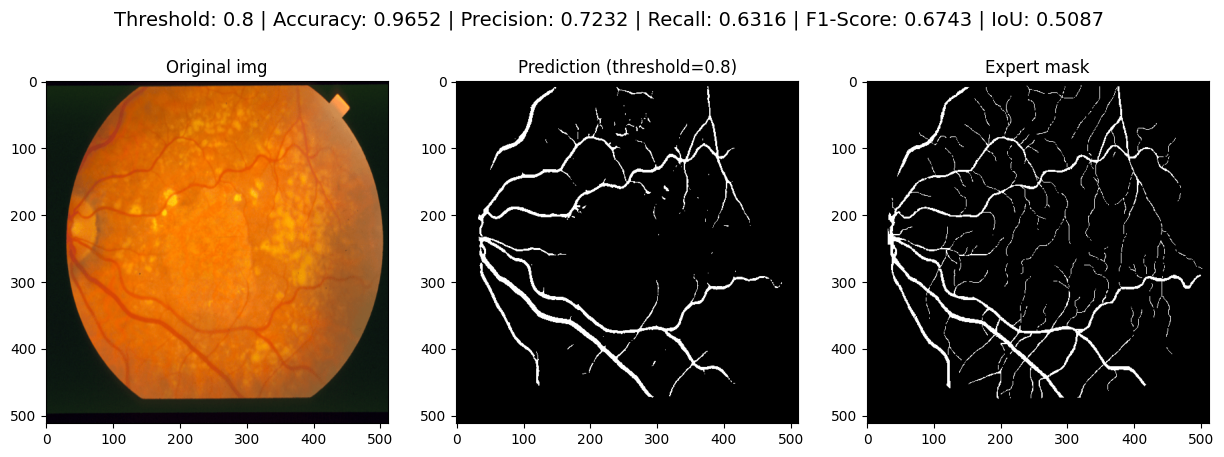

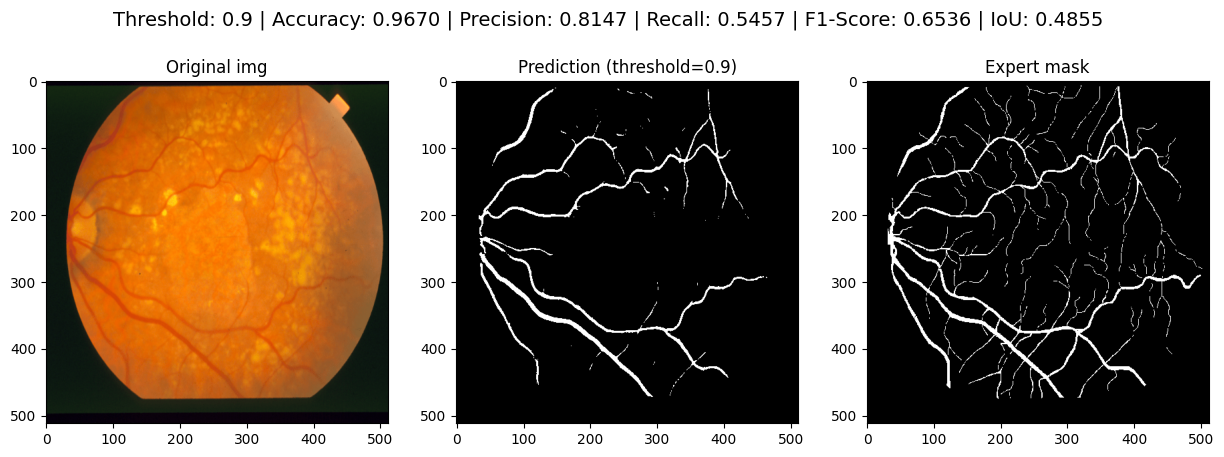

In [48]:
unet_model = load_model('custom_unet_model_v33.h5', compile=False)

unet_predict = unet_model.predict(test_images)

r1, r2, r3, r4 = 0.5, 0.7, 0.8, 0.9

unet_predict1 = (unet_predict > r1).astype(np.uint8)
unet_predict2 = (unet_predict > r2).astype(np.uint8)
unet_predict3 = (unet_predict > r3).astype(np.uint8)
unet_predict4 = (unet_predict > r4).astype(np.uint8)

test_masks_bin = (test_masks > 0.5).astype(np.uint8)

def show_result(idx, image, prediction, mask, threshold):
    accuracy = accuracy_score(mask.flatten(), prediction.flatten())
    precision = precision_score(mask.flatten(), prediction.flatten(), average='binary', zero_division=1)
    recall = recall_score(mask.flatten(), prediction.flatten(), average='binary')
    f1 = f1_score(mask.flatten(), prediction.flatten(), average='binary')
    iou = jaccard_score(mask.flatten(), prediction.flatten(), average='binary')
    
    plt.figure(figsize=(15, 5))
    plt.suptitle(f"Threshold: {threshold} | Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1-Score: {f1:.4f} | IoU: {iou:.4f}", fontsize=14)
    
    plt.subplot(1, 3, 1)
    plt.title("Original img")
    plt.imshow(image)
    
    plt.subplot(1, 3, 2)
    plt.title(f"Prediction (threshold={threshold})")
    plt.imshow(prediction.squeeze(), cmap='gray')
    
    plt.subplot(1, 3, 3)
    plt.title("Expert mask")
    plt.imshow(mask.squeeze(), cmap='gray')
    
    plt.show()

show_test_idx = random.sample(range(len(unet_predict)), 3)
for idx in show_test_idx: 
    show_result(idx, test_images[idx], unet_predict1[idx], test_masks_bin[idx], r1)
    show_result(idx, test_images[idx], unet_predict2[idx], test_masks_bin[idx], r2)
    show_result(idx, test_images[idx], unet_predict3[idx], test_masks_bin[idx], r3)
    show_result(idx, test_images[idx], unet_predict4[idx], test_masks_bin[idx], r4)
    print()
